# Sentiment analysis - Extra exploratory

Pakin Siwatammarat

In [7]:
!pip -q install wordcloud nltk

## Import library

In [152]:
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from nltk.util import bigrams
from collections import Counter
from wordcloud import WordCloud 
from pythainlp.tokenize import word_tokenize
from pythainlp.util import emoji_to_thai
from pythainlp.corpus import thai_stopwords

## Read data

In [3]:
with open('./data/train.txt', encoding="utf8") as f:
  train_texts = [line.strip() for line in f.readlines()]
  f.close()

with open('./data/train_label.txt', encoding="utf8") as f:
  train_labels = [line.strip() for line in f.readlines()]
  f.close()

In [4]:
# convert from list to pandas 
df = pd.DataFrame({"text": train_texts, "label": train_labels})

## Class distribution

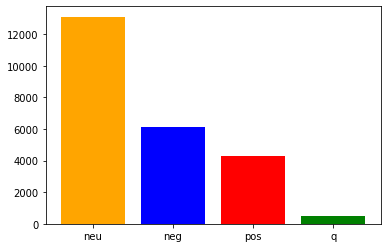

In [23]:
count  = df['label'].value_counts()
plt.bar(count.index, count.values, color=['orange', 'blue', 'red', 'green']);

In [103]:
count / df.shape[0]

neu    0.544612
neg    0.255164
pos    0.178698
q      0.021527
Name: label, dtype: float64

## Text preprocess

In [5]:
def replace_rep(text):
  def _replace_rep(m):
    c,cc = m.groups()
    return f'{c}xxrep'
  re_rep = re.compile(r'(\S)(\1{2,})')
  return re_rep.sub(_replace_rep, text)

def replace_url(text):
  URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
  return re.sub(URL_PATTERN, 'xxurl', text)

def replace_emoji(text):
  return emoji_to_thai(text, delimiters=(' ', ' '))

def replace_punctuation(text):
  punctuation = string.punctuation.replace(".", "") # remove all punctuation except . because we want to keep infomation some word such as "อ.", "จ." and etc.
  punctuation_translator = str.maketrans('', '', punctuation)
  return text.translate(punctuation_translator)

def preprocess(text):
  preprocess_text = text.lower().strip()
  preprocess_text = replace_url(preprocess_text)
  preprocess_text = replace_rep(preprocess_text)
  # preprocess_text = replace_emoji(preprocess_text)
  preprocess_text = replace_punctuation(preprocess_text)
  return preprocess_text

In [89]:
df['preprocess'] = df['text'].apply(lambda x: preprocess(x))
df['tokens'] = df['preprocess'].apply(lambda x: "|".join(filter(lambda x: x != "", word_tokenize(x))))

## Example 

In [166]:
for text in df[df['label'] == 'neg']['preprocess'].sample(10):
    print(text)

ไม่ถูกกับเบียร์ช้างครับ
แพ้ผ้าอนามัยแทบทุกยี่ห้อ ผื่นชอบขึ้น ไม่แพ้ยี่ห้อเดียวคือวิสเปอร์ห่อเขียว แต่ก็ขายแต่ในห้างไง เซเว่นไม่เอามาขายบ้าง ความลำบากของชะนีมีเมนส์
แต่งชุดธรรมดาคนก็มองแล้วนี่จะใส่ชุดไทยมองกันตาเหลือกเลยเชียว
แพงจังทำเดร็กเองเถอะ5xxrep
สาดแรงไม่ว่าแต่อย่าสาดโดนหน้าสิวันนากูไม่กันน้ำ👌 สงกรานต์2018
ไม่ไหวแล้วxxrep ฮอทพอทxxrep
วันนี้กินมาไม่เห็นลดเหลือ44บาทเลยค่ะ
โอ้ยอยากอะ แต่ไม่มีชุดไทย
วันก่อนไปกินเอมเคตามน้องฟ้าด้วย กินน้ำจิ้มน้อยลงด้วย
แต่กำหนดเพลาไม่เอื้อแก่ข้าเลยออเจ้า กว่าข้าเข้าพระนคร


In [167]:
for text in df[df['label'] == 'neu']['preprocess'].sample(10):
    print(text)

ผลิตภัณฑ์ยูเซอรินมีจำหน่ายที่ ร้านบูทส์ วัตสัน ร้านขายยาชั้นนำ โรงพยาบาลที่ร่วมรายการ และอีกหนึ่งช่องทางคุณลูกค้าสามารถซื้อผลิตภัณฑ์ออนไลน์ได้ทาง xxurl หรือทาง lazada ที่ xxurl และสามารถเลือกชมโปรโมชั่นต่างๆได้ที่ xxurl
สามีเรากินสิงห์กับช้าง
สาวเบียร์ช้าง ครับผม
5xxrep เลี้ยงใช่มั๊ย
ดูท่าจะแซ่บ
หรือกินนี้ดี5xxrep
รุ่นตาเพชร ถึงจะเป็นรุ่นเก่าแต่ก็เก๋าได้ตลอดกาล ภายในกว้าง ภายนอกก็ดูภูมิฐาน สรุปว่า รักอ่ะ ไปดูหนังกับแม่นะลูก
น้องหงษ์ทอง 5xxrep
ทดลองขับและรับจอง all new. suzuki. swift. สาขาร้อยเอ็ด ติดต่อ 0666xxrepมัชฉะ
แต่บีเอ็มก็มีระบบอื่นๆ ที่โตโยต้าไม่มีนี้ดิครับ ถุงลมตอนนี้ รถบางรุ่น 7แสน ถุงลมก็7 ใบแล้ว


In [168]:
for text in df[df['label'] == 'pos']['preprocess'].sample(10):
    print(text)

อยากอิเห้ย
ขอบคุณพี่ๆมากๆครับที่ทำตรงนี้ครับ
เชียงใหม่ ดอยตุง ภูชี้ฟ้า ดอยผาตั้ง เชียงของ เชียงราย ถึงสุราษฎร์ธานี หายห่วง และ ประหยัดน้ำมันสุดๆ กับ แคปติวา
ตอบแทนแอดคับ มันโหลดช้านิดนึงนะคับ ตอนนี้ยังลงชื่อได้ปกติ
มาเลี้ยงๆๆเด่วพาไป5xxrep
อากาศร้อนๆsofy cooling fresh ดีเว่อร์ น้องเย็น น้องหอม
ขอให้ผ่านลุล่วงไปด้วยดีครับ
อยากกิงๆ
อยากกินอ่อเทอวxxrep
ชอบๆครับกำลังอยากได้ nissan navara พอดีเลยครับ จัดโปรให้แบบนี้ถูกใจเลยครับ


In [169]:
for text in df[df['label'] == 'q']['preprocess'].sample(10):
    print(text)

จ่าขอความรู้หน่อยบุหรี่ไฟฟ้าข้อเสีย สุขภาพอย่างไรบ้างครับ
มาร์กของ innisfree wine sleeping mark ดีไหมคะน้องคุณ
พี่มีดีแม็กเอ็กซีรี่ตัวไฟตัดหมอกเดไร้ใหมครับ
โฮมโปรสาขาเลย ไม่มีโปรเหรอคะ
ลิป 3ce มีมั้ยค่ะ
สาขาซีคอนศรีนครินทร์ ปิดปรับปรุง จะเปิดให้บริการวันไหนคะ
anessa whitening essence aqua booster ใช้เป็นeverydayก่อนแต่งหน้าได้มั้ยคะ
camry hybrid 2013 ราคาเท่าไรครับ
ทำไมเข้าเวปนี้ไม่ได้เวปเดียว เครือข่ายเดียวคะ
มาสด้าโทรมไว้ไปป่าว


## WordCloud

In [90]:
wc = WordCloud(font_path='./font/THSarabunNew.ttf', 
               stopwords = ' '.join(list(thai_stopwords())),
               background_color="white",
               regexp=r"[\u0E00-\u0E7Fa-zA-Zก-ฮ']+",
               width = 1280,
               height = 720
              )

In [91]:
counter = Counter()
bi_counter = Counter()
for tokens in df['tokens']:
  words = tokens.split("|")
  counter.update(words)
  if len(words) >= 2: bi_counter.update(["".join(bi) for bi in list(bigrams(words))])

neg_counter = Counter()
bi_neg_counter = Counter()
for tokens in df[df['label'] == "neg"]['tokens']:
  words = tokens.split("|")
  neg_counter.update(words)
  if len(words) >= 2: bi_neg_counter.update(["".join(bi) for bi in list(bigrams(words))])

neu_counter = Counter()
bi_neu_counter = Counter()
for tokens in df[df['label'] == "neu"]['tokens']:
  words = tokens.split("|")
  neu_counter.update(words)
  if len(words) >= 2: bi_neu_counter.update(["".join(bi) for bi in list(bigrams(words))])

pos_counter = Counter()
bi_pos_counter = Counter()
for tokens in df[df['label'] == "pos"]['tokens']:
  words = tokens.split("|")
  pos_counter.update(words)
  if len(words) >= 2: bi_pos_counter.update(["".join(bi) for bi in list(bigrams(words))])

q_counter = Counter()
bi_q_counter = Counter()
for tokens in df[df['label'] == "q"]['tokens']:
  words = tokens.split("|")
  q_counter.update(words)
  if len(words) >= 2: bi_q_counter.update(["".join(bi) for bi in list(bigrams(words))])

In [ ]:
plt.rcParams['figure.figsize'] = [16, 9]

All classes

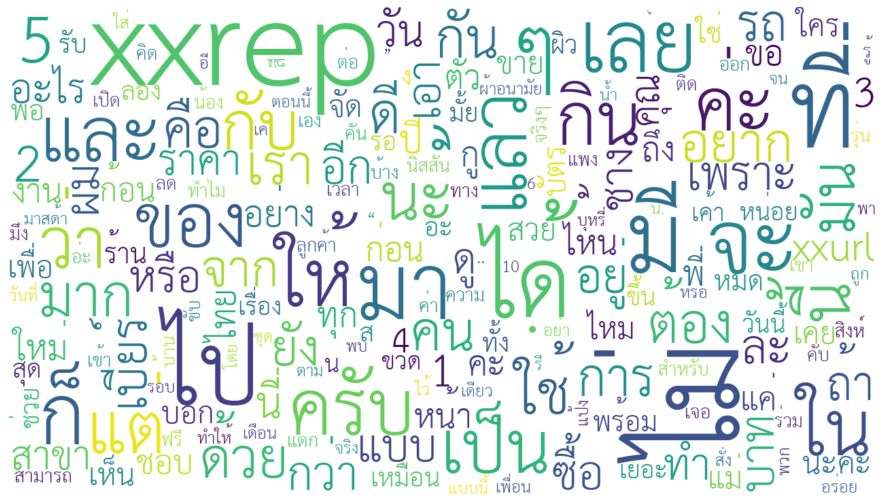

In [92]:
wc.generate_from_frequencies(counter)
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

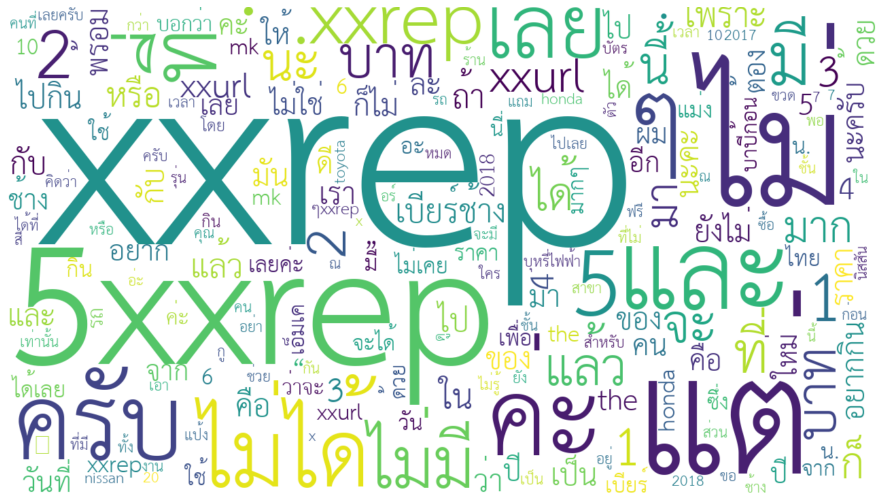

In [93]:
wc.generate_from_frequencies(bi_counter)
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

Negative class

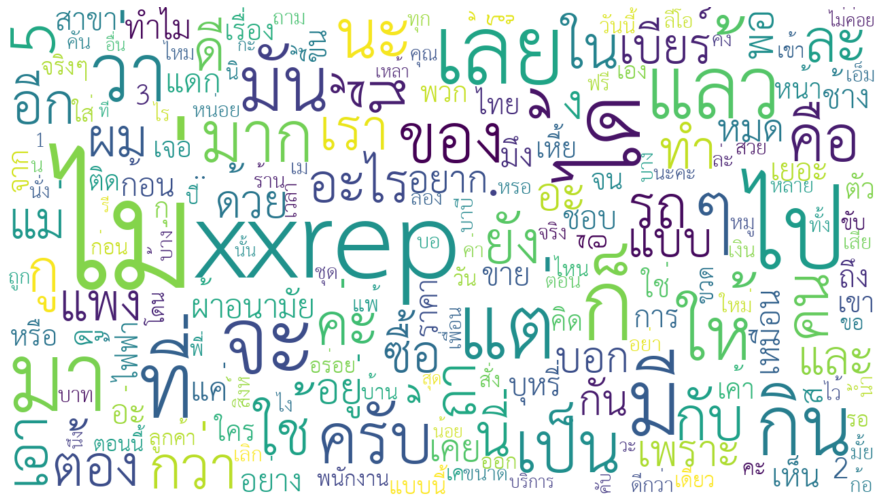

In [94]:
wc.generate_from_frequencies(neg_counter)
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

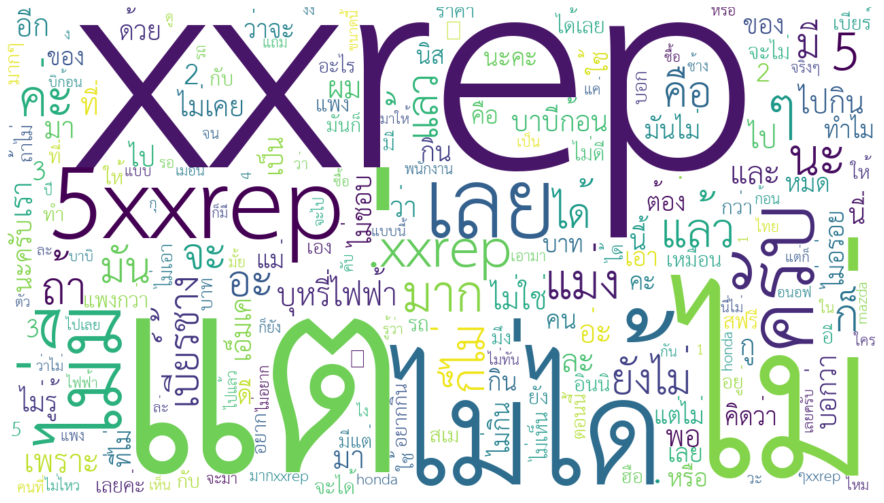

In [95]:
wc.generate_from_frequencies(bi_neg_counter)
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

Neutral class

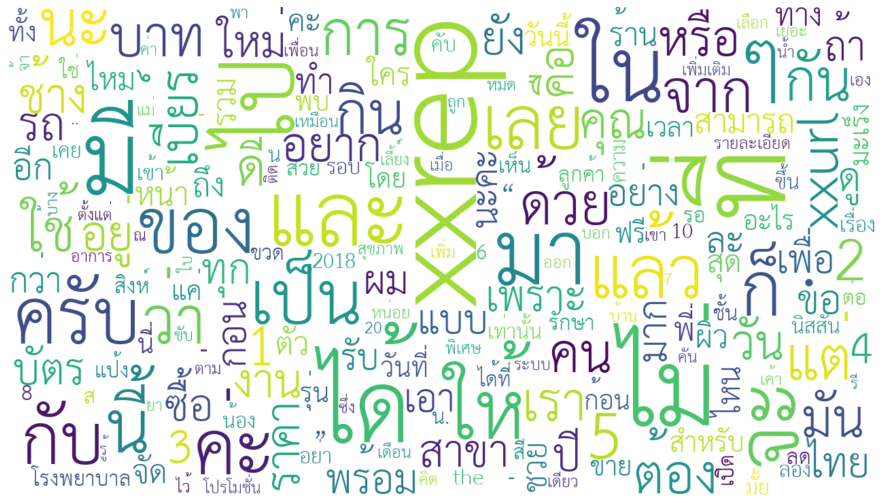

In [96]:
wc.generate_from_frequencies(neu_counter)
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

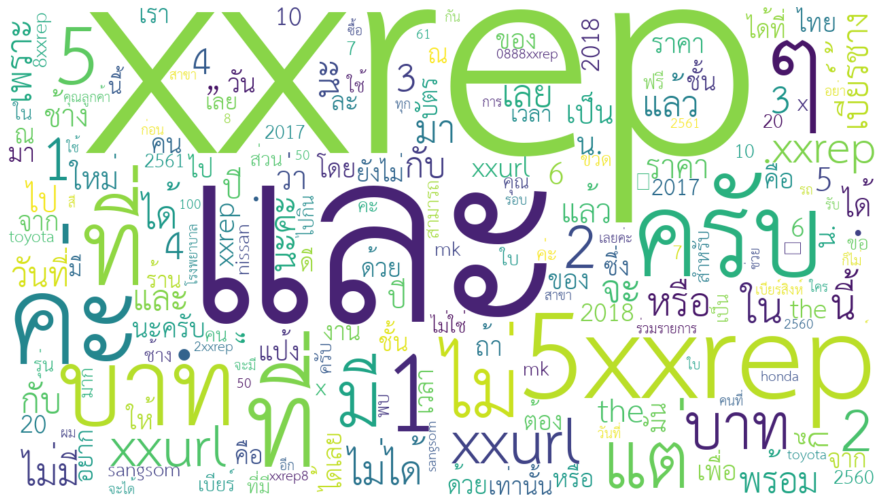

In [97]:
wc.generate_from_frequencies(bi_neu_counter)
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

Positive class

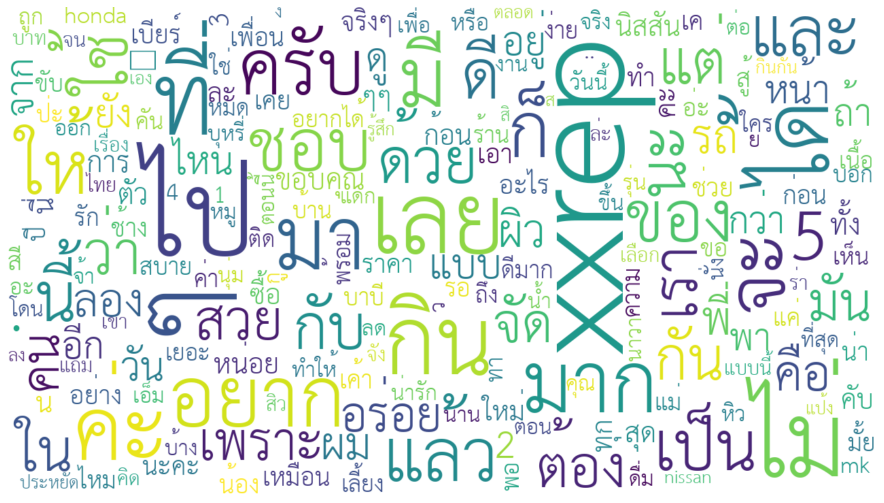

In [98]:
wc.generate_from_frequencies(pos_counter)
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

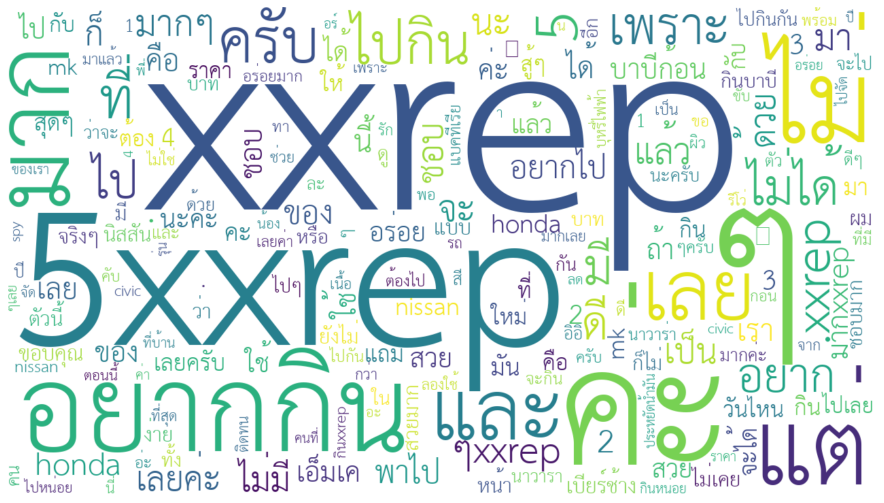

In [99]:
wc.generate_from_frequencies(bi_pos_counter)
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

Question class

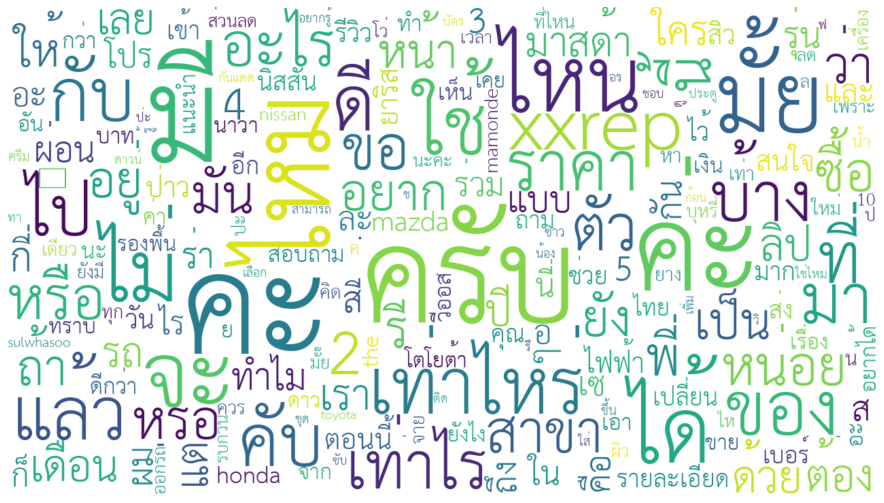

In [100]:
wc.generate_from_frequencies(q_counter)
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

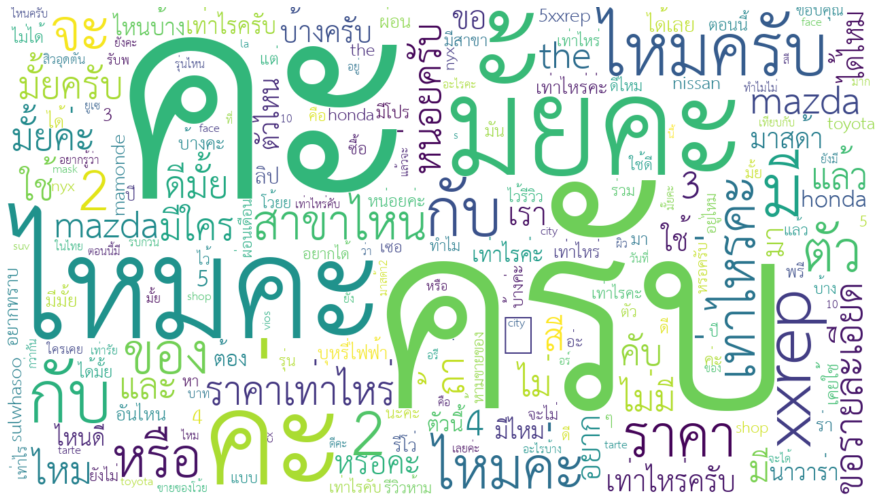

In [101]:
wc.generate_from_frequencies(bi_q_counter)
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word length

In [104]:
df['length'] = df['tokens'].apply(lambda x: len(x.split("|")))

text label  \
0      ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ   neu   
1                                                     คะ   neu   
2                            อิเหี้ยออมทำกูอยากกินเอ็มเค   neg   
3                                                    😅😅😅   neu   
4                                สวัสดีวันพุธ แนน อะไรนะ   neu   
...                                                  ...   ...   
24058                                     แม่งควายล้วนนน   neg   
24059                   ดอยสุเทพน้องง ไปหมดแล้วววว #pm25   neg   
24060                           ค่าชุดอาจจะแพงกว่าส่วนลด   neg   
24061                              รัฐต้องการแค่ภาษีครับ   neu   
24062  ™ ได้พัฒนาระบบเข้าสู่รุ่นที่สองแล้ว มาดูกันสิว...   neu   

                                              preprocess  \
0      ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ   
1                                                     คะ   
2                            อิเหี้ยออมทำกูอยากกินเอ็มเค   
3                                                 😅xxrep   
4                                สวัสดีวันพุธ แนน อะไรนะ   
...                                                  ...   
24058                                  แม่งควายล้วนxxrep   
24059                  ดอยสุเทพน้องง ไปหมดแล้วxxrep pm25   
24060                           ค่าชุดอาจจะแพงกว่าส่วนลด   
24061                              รัฐต้องการแค่ภาษีครับ   
24062  ™ ได้พัฒนาระบบเข้าสู่รุ่นที่สองแล้ว มาดูกันสิว...   

                                                  tokens  length  
0      ประเทศ|เรา|ผลิต|และ|ส่งออก|ยาสูบ|เยอะ|สุด|ใน|โ...      13  
1                                                     คะ       1  
2                    อิ|เหี้ย|ออม|ทำ|กู|อยาก|กิน|เอ็ม|เค       9  
3                                                😅|xxrep       2  
4                         สวัสดี|วัน|พุธ| |แนน| |อะไร|นะ       8  
...                                                  ...     ...  
24058                              แม่|ง|ควาย|ล้วน|xxrep       5  
24059       ดอย|สุเทพ|น้อง|ง| |ไป|หมด|แล้ว|xxrep| |pm|25      12  
24060                      ค่า|ชุด|อาจจะ|แพง|กว่า|ส่วนลด       6  
24061                          รัฐ|ต้องการ|แค่|ภาษี|ครับ       5  
24062  ™| |ได้|พัฒนา|ระบบ|เข้าสู่|รุ่น|ที่สอง|แล้ว| |...      27  

[24063 rows x 5 columns]

In [117]:
plt.rcParams['figure.figsize'] = [6, 4]

all classes

In [123]:
df['length'].describe()

count    24063.000000
mean        25.867930
std         41.140589
min          1.000000
25%          6.000000
50%         12.000000
75%         28.000000
max        672.000000
Name: length, dtype: float64

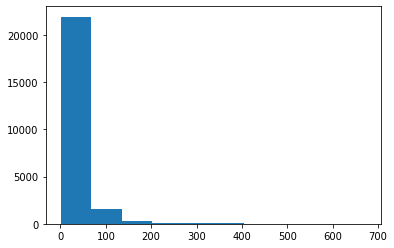

In [118]:
plt.hist(df['length'])
plt.show()

In [134]:
df['length'].quantile(0.9)

63.0

We need to set sequence length around 70 words to cover ~90% of the text

negative class

In [124]:
df[df['label'] == 'neg']['length'].describe()

count    6140.000000
mean       25.989577
std        29.166002
min         1.000000
25%         9.000000
50%        18.000000
75%        33.000000
max       455.000000
Name: length, dtype: float64

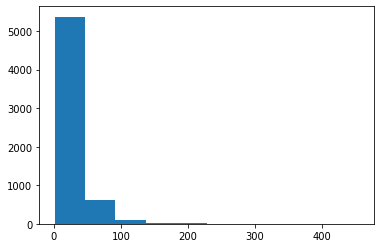

In [125]:
plt.hist(df[df['label'] == 'neg']['length'])
plt.show()

Natual class

In [126]:
df[df['label'] == 'neu']['length'].describe()

count    13105.000000
mean        29.074552
std         49.055896
min          1.000000
25%          5.000000
50%         11.000000
75%         30.000000
max        672.000000
Name: length, dtype: float64

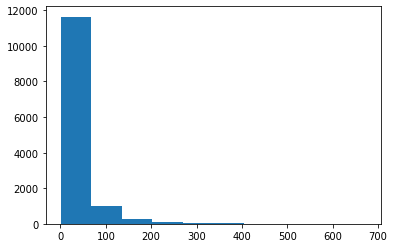

In [127]:
plt.hist(df[df['label'] == 'neu']['length'])
plt.show()

Positive Class

In [128]:
df[df['label'] == 'pos']['length'].describe()

count    4300.000000
mean       17.293023
std        27.980781
min         1.000000
25%         4.000000
50%         7.000000
75%        17.000000
max       506.000000
Name: length, dtype: float64

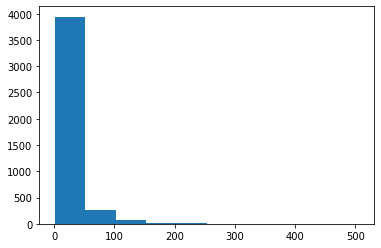

In [129]:
plt.hist(df[df['label'] == 'pos']['length'])
plt.show()

Question class

In [130]:
df[df['label'] == 'q']['length'].describe()

count    518.000000
mean      14.482625
std       12.855193
min        1.000000
25%        7.000000
50%       10.000000
75%       17.000000
max      120.000000
Name: length, dtype: float64

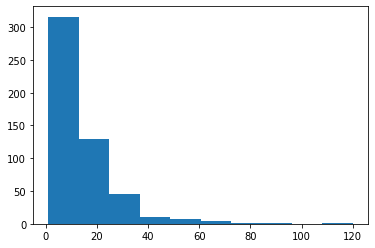

In [131]:
plt.hist(df[df['label'] == 'q']['length'])
plt.show()